In [48]:
import numpy as np
import timeit
import os
import pickle
from PIL import Image, ImageDraw

%run utils.ipynb
%run kernel_genetics.ipynb

In [58]:
# TODO favor for more complex during evolution
class Kernel:
    def __init__(self, size):
        super()
        self.genotype = KernelGenotype()
        self.size = size
        self.m = []
        self.m_ones = 0
    
    def __eq__(self, other): 
        if not isinstance(other, Kernel):
            return NotImplemented

        return self.genotype == other.genotype and self.size == other.size and np.array_equal(self.m, other.m) and self.m_ones == other.m_ones

    @classmethod
    def random_nog(cls, config):
        k = cls(config.kernel_size)
        assert k.size >= 2
        assert config.kernel_initial_complexity >= 0 and config.kernel_initial_complexity <= 1

        k.m = np.uint8(np.random.uniform(size=(k.size, k.size)) <= config.kernel_initial_complexity)
        k.m_ones = k.compute_ones()

        if k.m_ones == 0:
            # complete blank mask was generated. Put random pixel somewhere
            random_pos = np.random.randint(k.size, size=(2,))
            k.m[random_pos[0], random_pos[1]] = 1
            k.m_ones = k.compute_ones()
            assert k.m_ones == 1
            
        return k

    @classmethod
    def solid_nog(cls, config, solid_value):
        assert solid_value in [0, 1]
        
        k = cls(config.kernel_size)
        k.m = np.full((k.size, k.size), solid_value, dtype=np.uint8)
        k.m_ones = k.compute_ones()
        return k

    @classmethod
    def from_m_data_nog(cls, m_data):
        assert len(m_data.shape) == 2
        assert m_data.shape[0] == m_data.shape[1]
        assert m_data.shape[0] > 0
        
        k = cls(m_data.shape[0])
        k.m = m_data
        k.m_ones = k.compute_ones()
        return k

    def compute_ones(self):
        rv = 0
        # direct iteration is simplier to handle than np.unique_counts
        # because output of the latter may be any of [0, 1], [0], [1], []
        for x in np.nditer(self.m): 
            rv += (x == 1)

        return rv

    def get_complexity(self):
       return self.m_ones / (self.size * self.size)

    def get_inverted(self):
        k = Kernel(self.size)
        k.m = self.m.copy()
        k.m = 1 - k.m
        k.m_ones = k.compute_ones()
        return k

    def apply(self, image, image_bits_per_pixel):
        assert image_bits_per_pixel in [1, 8] # bw or grayscale only
        v = np.einsum('ij,ij->', self.m, image, dtype=np.uint32)
        # print(f'kms@ v={v} ones={self.m_ones}')

        if self.m_ones > 0:
            denom = self.m_ones
            denom *= 2 ** image_bits_per_pixel - 1
            v /= denom

        return v

    def to_image(self, inverted=True):
        sz = (self.size, self.size)
        bts = self.m.ravel() # 2d -> 1d

        if inverted:
            bts = 1 - bts # invert 0 -> 1 / 1-> 0
            
        bts = np.packbits(bts) # uint8 -> 1 bit
        return Image.frombytes('1', size=sz, data=bts)


In [59]:
class FenceKernel(Kernel):
    pass

In [60]:
my_config = Config()
ones_kernel = Kernel.solid_nog(my_config, 1)
zeros_kernel = Kernel.solid_nog(my_config, 0)
assert ones_kernel != zeros_kernel
assert ones_kernel == Kernel.solid_nog(my_config, 1)
assert zeros_kernel == Kernel.solid_nog(my_config, 0)


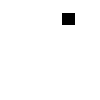
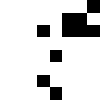
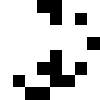
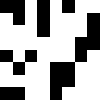
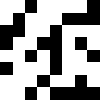
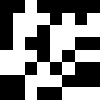
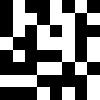
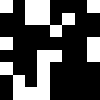
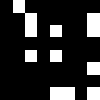
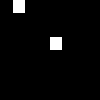
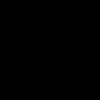

In [61]:
my_config = Config()
my_config.kernel_size = 8
kimgs = []
kimgcaps = dict()

for cmplx in range(0, 10 + 1):
    my_config.kernel_initial_complexity = cmplx / 10
    k = Kernel.random_nog(my_config)
    kimg = k.to_image().resize((100, 100))
    kimgs.append(kimg)
    kimgcaps[id(kimg)] = f'Complexity {cmplx} / {k.get_complexity()}'

display_images(kimgs, kimgcaps)

In [63]:
my_config = Config()

for i in range(2, 32):
    my_config.kernel_size = i
    k = Kernel.random_nog(my_config)
    match_score = k.apply(k.m, 1)
    assert match_score == 1, f'ks={i}, k.m={k.m}'

    invk = k.get_inverted()
    match_score_inv = k.apply(invk.m, 1)
    assert match_score_inv == 0

In [65]:
horz_line_image = Image.new('L', (8, 8), 0)
draw = ImageDraw.Draw(horz_line_image)
draw.rectangle([0, 2, 7, 5], 255)

vert_line_image = Image.new('L', (8, 8), 0)
draw = ImageDraw.Draw(vert_line_image)
draw.rectangle([2, 0, 5, 7], 255)

m_data = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
], dtype=np.uint8)

horz_line_kernel = Kernel.from_m_data(m_data)
shifted_horz_line_kernel = Kernel.from_m_data_nog(np.roll(m_data, -3, axis=0))
vert_line_kernel = Kernel.from_m_data_nog(m_data.T)
vert_line_kernel.apply(vert_line_image, 8)
shifted_vert_line_kernel = Kernel.from_m_data_nog(np.roll(m_data.T, -3, axis=1))

assert horz_line_kernel.apply(horz_line_image, 8) == 1
assert vert_line_kernel.apply(vert_line_image, 8) == 1
assert shifted_horz_line_kernel.apply(horz_line_image, 8) == 0
assert shifted_vert_line_kernel.apply(vert_line_image, 8) == 0

display_images(
    [vert_line_image.resize((100, 100)), 
     horz_line_image.resize((100, 100)), 
     vert_line_kernel.to_image(inverted=False).resize((100, 100)),
     horz_line_kernel.to_image(inverted=False).resize((100, 100)),
     shifted_horz_line_kernel.to_image(inverted=False).resize((100, 100)),
     shifted_vert_line_kernel.to_image(inverted=False).resize((100, 100)),
    ]
)

AttributeError: type object 'Kernel' has no attribute 'from_m_data'

In [ ]:
config = Config()

image_fnames = os.listdir(config.dataset_path)
fname_i = np.random.randint(0, len(image_fnames))
image_fname = os.path.join(config.dataset_path, image_fnames[fname_i])

z = Image.open(image_fname)
z_2d_bytes = np.frombuffer(z.tobytes(), dtype=np.uint8).reshape(32, 32)

k = Kernel.random(config)
match_score = k.apply(z_2d_bytes, 8)
print(f'Match score over image "{image_fname}" = {match_score}')

display_images([z.resize([320, 320]), k.to_image().resize((320, 320))])

In [ ]:
class KernelGrid:
    def __init__(self, grid_size):
        super()
        self.size = grid_size
        self.fence_kernel = FenceKernel(0) # empty kernel
        self.indices = dict()

    def __eq__(self, other): 
        if not isinstance(other, KernelGrid):
            return NotImplemented

        return self.size == other.size and self.indices == other.indices

    @classmethod
    def random(cls, config):
        g = cls(config.grid_size)
        g.reset(config)
        return g

    @classmethod
    def from_kernels(cls, kernels):
        assert len(kernels) == 2
        assert len(kernels[0]) == len(kernels[1])
        assert len(kernels[0]) > 0

        g = cls(len(kernels[0]))
        
        for i in range(g.size):
            for j in range(g.size):
                kernel = kernels[i][j]
                g.indices[(i, j)] = kernel
                
        return g

    def reset(self, config):
        for i in range(self.size):
            for j in range(self.size):
                kernel = Kernel.random(config)
                self.indices[(i, j)] = kernel

    def run_image_st(self, img, kernel_score_threshold):
        # singlethreaded
        matched_kernels = []
        indices_items = self.indices.items()
        
        for ij, k in indices_items:
            score = k.apply(img, 8)
            # print(f'kms@ {ij} {score}')
            
            if score >= kernel_score_threshold:
                matched_kernels.append((ij, k))

            self.get_neighbours(ij)

        return len(matched_kernels) / len(indices_items)

    def run_image_mt(self, img, kernel_score_threshold):
        # multithreaded (if ever needed)
        assert False

    def get_neighbours(self, node_indices):
        def _gn(off_i, off_j):
            neighbour_indices = node_indices[0] + off_i, node_indices[1] + off_j
            
            if any(map(lambda ni: ni < 0 or ni >= self.size, neighbour_indices)):
                # print(f'kms@ fence {neighbour_indices}')
                return neighbour_indices, self.fence_kernel

            # print('kms@ normal')
            return neighbour_indices, self.indices[neighbour_indices]

        # Order: l, lt, t, rt, r, rb, b, lb
        return (\
            _gn(-1, 0),
            _gn(-1, 1),
            _gn(0, 1),
            _gn(1, 1),
            _gn(0, 1),
            _gn(1, -1),
            _gn(0, -1),
            _gn(-1, -1)
        )

In [ ]:
my_config = Config()
kernels1 = [
    [horz_line_kernel, shifted_horz_line_kernel],
    [vert_line_kernel, shifted_vert_line_kernel],
]
kernels2 = [
    [vert_line_kernel, shifted_vert_line_kernel],
    [horz_line_kernel, shifted_horz_line_kernel],
]
grid1 = KernelGrid.from_kernels(kernels1)
grid2 = KernelGrid.from_kernels(kernels2)
assert grid1 != grid2
grid1_ser = pickle.dumps(grid1)
grid1_loaded = pickle.loads(grid1_ser)
assert grid1 == grid1_loaded

In [ ]:
%time
KernelGrid.random(config).run_image_st(z, config.kernel_score_threshold)